# Chapter 5: Train A Transformer to Add Captions to Images

This chapter covers:

* Similarities between image-to-text generation and text-to-image generation
* Building a Transformer from scratch to add captions to images
* Training an image-to-text Transformer with Flickr 8k dataset
* Adding captions to images with the trained image-to-text Transformer 


Training a multi-modal Transformer for text-to-image generation (i.e., adding captions to images) and training one for image-to-text generation (i.e., generating images based on textual descriptions) share several similarities, primarily because both tasks involve learning complex mappings between textual and visual modalities. Understanding and training multi-modal Transformers for image-to-text generation first can provide valuable insights and foundational knowledge, making the more complex task of text-to-image generation more manageable. For this very reason, you'll build and train an image-to-text Transformer from scratch in this chapter to lay a solid foundation for text-to-image generation skills in later chapters.

Specifically, you'll go through all the steps needed to build a multi-model Transformer to add captions to images. You'll use the Flickr 8K dataset as the training data to train the model. Once the model is trained, you can feed any image to the model and obtain a coherent caption describing what's in the image. 

Both image-to-text and text-to-image tasks often use similar Transformer-based architectures. These models typically include encoders and decoders that handle different modalities. The architecture is designed to learn representations from both text and images, allowing the model to translate between these modalities. 

To train a model to add captions to images in this chapter, we'll create an encoder-decoder Transformer to serve as our image-to-text multimodal model. To create an encoder, we'll build a vision Transformer (ViT) to help in understanding visual features in images. As we learned in Chapter 3, the ViT treats an image as a sequence of image patches and extracts features from them. The trained ViT effectively encodes these features and compresses them to a latent space that the natural language model understands. 

To create a decoder in the multi-modal model, we'll use one similar to the decoder in the German-to-English translator we built in Chapter 2. The difference lies in the input to the decoder. In Chapter 2, the input to the decoder is the encoder's output that captures the meaning of a German phrase. The decoder in the German-to-English translator generates the English translation in an autoregressive fashion. It starts with the BOS token, which signals the start of a sentence. It then generates the translation one token at a time. In each iteration, it predicts the next token based on the encoder's output and previous text tokens in the sentence. 

In this chapter, the decoder in the image-to-text Transformer works in a similar fashion. The input to the decoder is the encoder's output that captures the feature maps of the input image. The decoder in the image-to-text Transformer generates the caption one text token at a time, starting with the token BOS, which signals the start of the caption. In each iteration, it predicts the next token based on the image embedding generated by the ViT encoder and previous tokens in the caption. When the predicted next token is EOS, which signals the end of the caption, the image-to-text generation process stops.

Image-to-text models help in understanding how visual features can be effectively encoded and mapped to linguistic features. This knowledge is crucial when reversing the task for text-to-image generation. Successful training of image-to-text models ensures the model can effectively understand and encode visual information, a critical step before attempting to generate visual data from text. 

Generating high-quality images that are visually coherent and match the given textual description is a more challenging task. The model must capture complex visual details and produce images that are both realistic and contextually accurate. Ensuring the generated image maintains overall coherence (e.g., correct object shapes, consistent lighting, and textures) adds another layer of complexity. We'll tackle these challenges in the rest of the book by using tools such as U-Nets, diffusion models, variational autoencoders, vision Transformers, and so on. 

# 1	Prepare the Training Dataset
You’ll use the Flickr 8k dataset to train the image-to-text Transformer in this chapter. The Flickr 8K dataset is a collection of more than 8,000 photographs sourced from the Flickr website, each annotated with five different descriptive captions provided by human annotators. This dataset is specifically designed for developing and evaluating image captioning models. The diverse set of images typically depict people or animals performing various activities in a wide range of settings. The annotations are intended to facilitate the training of machine learning models that can generate descriptive text for images automatically. Other datasets for this purpose include the Flickr 30k dataset, which has about 30,000 training images, and the MS COCO (Microsoft Common Objects in Context) dataset, which consists of 328,000 images. We chose Flickr 8k to reduce the computational resources needed for training the model.

In this section, you'll download the dataset, split them into a train and test set, and place them in batches for training later. 

The Python programs in this chapter are adapted from two great GitHub repositories: one by Senad Kurtisi (https://github.com/senadkurtisi/pytorch-image-captioning) and one by Luke Ditria (https://github.com/LukeDitria/pytorch_tutorials).

## 1.1 Download and Visualize Flickr 8k Images
You can download the Flickr 8k images and the associated text captions from the Kaggle website (https://www.kaggle.com/datasets/adityajn105/flickr8k). Log in to your Kaggle account, download the zip file, extract the data from the zip file. Place everything in the folder /files/ on your computer.  

Since we need to split data into train and test, we'll also download a zip file from Andrej Karpathy's website (http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip). Unzip the file and place the file dataset_flickr8k.json in the /files/ folder on your computer. 

We first read the JSON file as follows:

In [1]:
import json

with open('files/dataset_flickr8k.json', 'r') as fb:
    data = json.load(fb)

All the Flickr 8k images should be stored in the /files/Images/ folder on your computer. We'll split them into train and test, like so:

In [2]:
from collections import Counter

train_image_paths = []
train_image_captions = []
test_image_paths = []
test_image_captions = []
word_freq = Counter()

max_len=50
for img in data['images']:
    captions = []
    for c in img['sentences']:
        word_freq.update(c['tokens'])
        if len(c['tokens']) <= max_len:
            captions.append(c['tokens'])
    if len(captions) == 0:
        continue
    path ="files/Images/"+img['filename'] 
    if img['split'] in {'train', 'val', 'restval'}:
        train_image_paths.append(path)
        train_image_captions.append(captions)
    elif img['split'] in {'test'}:
        test_image_paths.append(path)
        test_image_captions.append(captions)

The list train_image_paths contains the image paths of the training set, while train_image_captions contains the corresponding captions. Note that the captions have already been divided into tokens so that we don't need to tokenize from scratch. Alternatively, you can change c['tokens'] to c['raw'] in the above code cell and collect the captions so that you can tokenize them yourself later. 

The lists test_image_paths and test_image_captions contain the image paths and captions of the test set. The counter object word_freq counts how often each token is used and we'll use it to build a vocabulary later. 

Next, we make sure that the number of images matches the number of groups of captions in both the training and test sets. We also count the number of observations in the two datasets, as follows:

In [3]:
assert len(train_image_paths)==len(train_image_captions)
assert len(test_image_paths)==len(test_image_captions)
print(f"there are {len(train_image_paths)} training images")
print(f"there are {len(test_image_paths)} test images")

there are 7000 training images
there are 1000 test images


We have 7000 training images and 1000 test images. 

Next, we create a vocabulary for the English language for text generation purposes.

## 1.2 Build A Vocabulary of Tokens
Based on the counter object word_freq, we'll create a vocabulary of English tokens as follows:

In [4]:
# Create a dictionary to map tokens to indexes
min_word_freq=0
words = [w for w in word_freq.keys() if word_freq[w]>min_word_freq]
word2idx = {k:v + 4 for v,k in enumerate(words)}
# hard code in the special tokens
word2idx['<pad>'] = 0
word2idx['<start>'] = 1
word2idx['<end>'] = 2
word2idx['<unk>'] = 3

The dictionary word2idx maps English tokens to indexes. We manually insert four special tokens. The padding token '<pad>' pads the captions in a batch to the same length so that we can feed them to the Transfomer for training later. The token '<start>' signals the start of a caption and '<end>' signals the end of a caption. Finally, the token '<unk>' is used in case a token is not found in the dictionary word2idx. 

We can use the dictionary word2idx to convert captions to a sequence of indexes, as follows:

In [5]:
indexes=[word2idx.get(token,3) for 
         token in test_image_captions[0][0]]
print(indexes)

[12, 18, 318, 11, 12, 13, 11, 45, 30, 4, 234]


Tokens in the first caption for the first image in the test set are converted to a sequence of numbers, as shown above. 

We create another dictionary, idx2word, to map indexes to tokens, like so:

In [6]:
idx2word={v:k for k, v in word2idx.items()}
tokens=[idx2word.get(idx,"<unk>") for 
         idx in indexes]
print(tokens)
print(f"there are {len(idx2word)} unique tokens")

['the', 'dogs', 'are', 'in', 'the', 'snow', 'in', 'front', 'of', 'a', 'fence']
there are 8387 unique tokens


The dictionary idx2word translates a sequence of numbers back to tokens, as shown above. This shows that the first caption for the first image in the test set must be "the dogs are in the snow in front of a fence." Our vocabulary has a total of 8387 unique tokens. 

## 1.3 Prepare the Training Dataset
To save space, we’ll place most helper functions and classes in a local module, caption_util. Download the file caption_util.py from the book’s GitHub repository https://github.com/markhliu/txt2img and place it in the /utils/ folder on your compute

Open the file caption_util.py and have a look at the functions and classes in it. In particular, we define a FlickrD() class in the file to generate image tensors, input tokens, output tokens, and the attention mask. 

The training and test data are generated as follows:

In [7]:
from utils.caption_util import FlickrD

trainset=FlickrD(train_image_paths,
  train_image_captions,word2idx)    
testset=FlickrD(test_image_paths,
  test_image_captions,word2idx)   

We then put them in batches for training and testing:

In [8]:
from torch.utils.data import DataLoader  

train_loader = DataLoader(trainset, 
                          batch_size=128, 
                          shuffle=True)     
test_loader = DataLoader(testset, 
                        batch_size=128, 
                        shuffle=True)  

We can retrieve a batch of testing images and their corresponding input indexes, output indexes, and attention masks.

In [9]:
test_images,test_tokens,\
    test_targets,test_mask=next(iter(test_loader))

The dictionary *de_word_dict* maps each German token to an integer and the dictionary *de_idx_dict* maps integers back to German tokens. Below, we convert the first German phrase to numerical representations:

In [10]:
import torch
torch.save((test_images,test_tokens),"files/tests.pt")

The following code cell converts the above numerical representations back to German tokens and restores the original German phrase:

# 2. Create A Multi-Modal Image-to-Text Transformer
In this section, we'll create a multi-model image-to-text Transformer as our model. 

To save space, we'll define the functions and classes related to the construction of the model in the caption_util.py file that you downloaded earlier. 

## 2.1. Define A Vision Transformer As The Image Encoder
Similar to Chapter 4, we'll construct a vision Transformer (ViT) to be the encoder in our model. The purpose of the ViT is to compress an image as an abstract vector representation in the latent space.

First, define the following extract_patches() function in the local module to convert an image to patches.

```python
def extract_patches(image_tensor, patch_size=8):
    # Get the dimensions of the image tensor
    bs, c, h, w = image_tensor.size()
    # Define the Unfold layer 
    unfold = torch.nn.Unfold(kernel_size=patch_size,
                             stride=patch_size)
    # Apply Unfold to the image tensor
    unfolded = unfold(image_tensor)
    # Reshape the unfolded tensor to desired shape
    unfolded = unfolded.transpose(1, 2).reshape(bs,
                    -1, c * patch_size * patch_size)
    return unfolded
```    

The function takes an image and applies an unfold layer to it. Each input image has a shape of (3, 128, 128), meaning 3 color channels, with width and height of 128 pixels. Each patch is 8 pixels wide and 8 pixels tall, so each image is divided into 256 patches. Each patch in each color channel has 8x8=64 pixels. Since there are 3 color channels, the total number of pixels in each patch is 3x64=192.

You can verify the results as follows: 

In [11]:
from utils.caption_util import extract_patches

image=test_images[0].unsqueeze(0)
patches=extract_patches(image,patch_size=8)
print(patches.shape)

torch.Size([1, 256, 192])


The ViT treats an image as a sequence of patches. These patches have orders. To model the orders of patches in a sequence, we define the following SinusoidalPosEmb() class in the local module:

```python
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim,
                                 device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
```        

The class is similar to the sinusoidal positional encoding we used in Chapter 2. 

We define one single AttentionBlock() class in the local module as follows:

```python
class AttentionBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, masking=True):
        super(AttentionBlock, self).__init__()
        self.masking = masking
        self.multihead_attn=nn.MultiheadAttention(hidden_size,
                                        num_heads=num_heads,
                                        batch_first=True,
                                        dropout=0.0)
    def forward(self, x_in, kv_in, key_mask=None):
        if self.masking:
            bs, l, h = x_in.shape
            mask = torch.triu(torch.ones(l, l, 
                     device=x_in.device), 1).bool()
        else:
            mask = None          
        return self.multihead_attn(x_in, kv_in, kv_in,
             attn_mask=mask,key_padding_mask=key_mask)[0]
```                                   

We'll use the AttentionBlock() class to calculate both self-attentions and cross attentions. The cross attention captures the relation between the image embedding and the text embedding. 

Next, we define a TransformerBlock() class in the local module:

```python
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, 
                 decoder=False, masking=True):
        super(TransformerBlock, self).__init__()
        self.decoder = decoder
        self.norm1 = nn.LayerNorm(hidden_size)
        self.attn1 = AttentionBlock(hidden_size=hidden_size, 
                                    num_heads=num_heads, 
                                    masking=masking)
        if self.decoder:
            self.norm2 = nn.LayerNorm(hidden_size)
            # Self-attention mechanism for the decoder with no masking
            self.attn2 = AttentionBlock(hidden_size=hidden_size, 
                            num_heads=num_heads, masking=False)
        # Layer normalization for the output before the MLP
        self.norm_mlp = nn.LayerNorm(hidden_size)
        # Multi-layer perceptron (MLP)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size * 4),
                                 nn.ELU(),
                                 nn.Linear(hidden_size * 4, hidden_size))            
    def forward(self, x, input_key_mask=None, 
                cross_key_mask=None, kv_cross=None):
        # Perform self-attention operation
        x = self.attn1(x, x, key_mask=input_key_mask) + x
        x = self.norm1(x)
        # If decoder, perform additional cross-attention layer
        if self.decoder:
            x = self.attn2(x, kv_cross,key_mask=cross_key_mask) + x
            x = self.norm2(x)
        # Apply MLP and layer normalization
        x = self.mlp(x) + x
        return self.norm_mlp(x)
```

The TransformerBlock() class can be used to create an encoder block or a decoder block. 

Now, we can go ahead and create an encoder in the local module as follows: 

```python
class VisionEncoder(nn.Module):
    def __init__(self, image_size, channels_in, 
                 patch_size=16, hidden_size=128, 
                 num_layers=3, num_heads=4):
        super(VisionEncoder, self).__init__()
        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in*patch_size*patch_size,
                               hidden_size)
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding=nn.Parameter(torch.empty(1,seq_length, 
                              hidden_size).normal_(std=0.02))      
        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, 
        decoder=False, masking=False) for _ in range(num_layers)
        ])           
    def forward(self, image):  
        bs = image.shape[0]
        patch_seq = extract_patches(image, 
                                    patch_size=self.patch_size)
        patch_emb = self.fc_in(patch_seq)
        # Add a unique embedding to each token embedding
        embs = patch_emb + self.pos_embedding
        # Pass the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs) 
        return embs
```

A batch of images are first fed to the extract_patches() function we defined earlier. The positional encodings of these patches are added to the embeddings. The sum then goes through multiple encoder blocks. 

## 2.2. The Decoder to Generate Text
The decoder is defined in the local module as follows:

```python
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, 
                 num_layers=3, num_heads=4):
        super(Decoder, self).__init__()
        # Create an embedding layer for tokens
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Initialize the embedding weights
        self.embedding.weight.data=0.001*self.embedding.weight.data
        # Initialize sinusoidal positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, 
                             decoder=True) for _ in range(num_layers)
        ])        
        # Define a linear layer for output prediction
        self.fc_out = nn.Linear(hidden_size, num_emb)
        
    def forward(self, input_seq, encoder_output, 
                input_padding_mask=None, 
                encoder_padding_mask=None):        
        # Embed the input sequence
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape
        # Add positional embeddings to the input embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1,
                             l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        # Pass the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs, 
                           input_key_mask=input_padding_mask, 
                           cross_key_mask=encoder_padding_mask, 
                           kv_cross=encoder_output)       
        return self.fc_out(embs)
```

The image-to-text Transformer combines the vision encoder and the text decoder, as defined in the local module:

```python
class VisionEncoderDecoder(nn.Module):
    def __init__(self, image_size, channels_in,
                 num_emb, patch_size=16, 
                 hidden_size=128, num_layers=(3, 3),
                 num_heads=4):
        super(VisionEncoderDecoder, self).__init__()    
        # Create an encoder and decoder with specified parameters
        self.encoder = VisionEncoder(
            image_size=image_size, channels_in=channels_in, 
            patch_size=patch_size, hidden_size=hidden_size, 
            num_layers=num_layers[0], num_heads=num_heads)
        self.decoder = Decoder(num_emb=num_emb, 
            hidden_size=hidden_size, 
            num_layers=num_layers[1], num_heads=num_heads)
    def forward(self, input_image, target_seq, padding_mask):
        # Generate padding masks for the target sequence
        bool_padding_mask = padding_mask == 0
        # Encode the input sequence
        encoded_seq = self.encoder(image=input_image)
        # Decode the target sequence using the encoded sequence
        decoded_seq = self.decoder(input_seq=target_seq, 
                         encoder_output=encoded_seq, 
                    input_padding_mask=bool_padding_mask)
        return decoded_seq
```        

# 3 Train the Image-to-Text Transformer
We'll use the Flickr 8k dataset to train the multi-model image-to-text Transformer. 

We'll first formally set up the model by using the encoder and decoder defined in the last section. We'll then set up the loss function, optimizer, and the training loop. 

## 3.1	Create An Image-to-Text Model
We first define a few hyperparameters:

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Embedding Size
hidden_size = 192
# Number of Transformer blocks for the (Encoder, Decoder)
num_layers = (6, 6)
# MultiheadAttention Heads
num_heads = 8
# Size of the patches
patch_size = 8

The model is created by instantiating the VisionEncoderDecoder() class:

In [13]:
from utils.caption_util import VisionEncoderDecoder

caption_model = VisionEncoderDecoder(
    image_size=128, channels_in=3, 
    num_emb=len(word2idx), patch_size=patch_size, 
    num_layers=num_layers,hidden_size=hidden_size, 
    num_heads=num_heads).to(device)

The optimizer and loss function are defined as follows:

In [14]:
# Initialize the optimizer with above parameters
from torch import nn
optimizer = torch.optim.Adam(caption_model.parameters(),
                             lr=0.0001)
scaler = torch.cuda.amp.GradScaler()
# Define the loss function
loss_fn = nn.CrossEntropyLoss(reduction="none")

Let's count the number of parameters in the model:

In [15]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in caption_model.parameters():
    num_model_params += param.flatten().shape[0]
print(f"This model has {num_model_params} parameters")

This model has 9545219 parameters


The model has less than 10 million parameters. 

## 3.2 The Training Loop for the Image-to-Text Transformer
We train the model as follows: 

In [16]:
from tqdm import tqdm
# Iterate over epochs
for epoch in range(0, 50):
    # Set the model in training mode
    caption_model.train()
    eloss=0
    # Iterate over the training data loader
    for images,inputs,outputs,masks in tqdm(train_loader):
        images = images.to(device)
        tokens_in = inputs.to(device)
        padding_mask = masks.to(device)
        target_ids = outputs.to(device)
        with torch.cuda.amp.autocast():
            # Forward pass
            pred = caption_model(images, tokens_in, 
                                 padding_mask=padding_mask)
            # Compute the loss
            loss = (loss_fn(pred.transpose(1, 2),
                            target_ids) * padding_mask).mean()        
        # Backpropagation
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # Log the training loss
        eloss+=loss.item()
    print(f"epoch {epoch}, loss is {eloss/len(train_loader)}")
torch.save(caption_model.state_dict(),"files/caption.pth")

The training takes several hours with GPU training. Alternatively, you can download the pretrained model from my website at https://gattonweb.uky.edu/faculty/lium/gai/caption.zip.

# 4. Add Captions to Images with the Trained Model
We will test the trained model by generating captions to images in the test set. 

We first define a caption() function to add captions to images. We then apply the function on images in the test set. Finally, we place both the original caption and the generated caption on top of the images to compare how good the trained model is.

## 4.1 Define A Caption() Function To Add Captions
We first define the following caption() function:

In [17]:
def caption(image,temp=1.0):
    # Add the Start-Of-Sentence token to the prompt
    sos_token = 1 * torch.ones(1, 1).long()
    log_tokens = [sos_token]
    caption_model.eval()
    with torch.no_grad():
        # Encode the input image
        image_embedding = caption_model.encoder(image.to(device))
        # Generate the caption tokens
        for i in range(50):
            input_tokens = torch.cat(log_tokens, 1)
            # Decode input tokens into the next predicted tokens
            data_pred = caption_model.decoder(
                input_tokens.to(device),image_embedding)
            # Sample from the distribution based on temperature
            dist = Categorical(logits=data_pred[:, -1] / temp)
            next_tokens = dist.sample().reshape(1, 1)
            # Append the next predicted token to the sequence
            log_tokens.append(next_tokens.cpu())
            # Stop if the End-Of-Caption token is predicted
            if next_tokens.item() == 2:
                break  
    # Convert the list of token indices to a tensor
    pred_text = torch.cat(log_tokens, 1)
    pred_text_strings = [idx2word.get(i,"UNK") for
                 i in pred_text[0].tolist() if i>3]
    # Join the token strings to form the predicted text
    pred_text = " ".join(pred_text_strings)
    return pred_text

The function caption() takes two arguments. The first is the image you want to add caption to. The second is the temperature parameter, which controls the creativeness of the generated text.

To generate caption, we first feed the image to the encoder in the trained model to obtain the image embedding. The encoder produces an abstract vector representation as the image embedding and passes it on to the decoder. 
Based on the image embeddinge produced by the encoder, the decoder in the trained model starts generating captiong in an autoregressive manner, starting with the beginning token BOS (with index value 1)". In each time step, the decoder generates the most likely next token based on previously generated tokens, until the predicted token is EOS (with index value 2)", which signals the end of the sentence. 

## 4.2.	See A Few Examples
We define a compare() function:

In [18]:
def compare(images, captions, index, temp=1.0):
    image = images[index].unsqueeze(0)
    capi=captions[index]
    capt=[idx2word.get(i,"UNK") for i in capi.tolist() if i>3]
    cap=" ".join(capt)
    pred=caption(image,temp=temp)
    out=torchvision.utils.make_grid(image, 1, normalize=True)
    plt.figure(figsize=(5,10),dpi=200)
    out = torchvision.utils.make_grid(image, 1, normalize=True)
    plt.imshow(out.numpy().transpose((1, 2, 0)))
    plt.title(
      "Original caption:\n"+cap+"\nGenerated caption:\n"+pred) 
    plt.axis("off")
    plt.show()

We apply the compare() function on the first image in the test set:

In [19]:
from torch.distributions import Categorical
import torchvision
import matplotlib.pyplot as plt

caption_model.load_state_dict(torch.load("files/caption.pth",
    map_location=device))

compare(test_images,test_tokens, 0, temp=0.75) 

Given the random nature of the output, you'll have different results. I provide several successful examples below. 

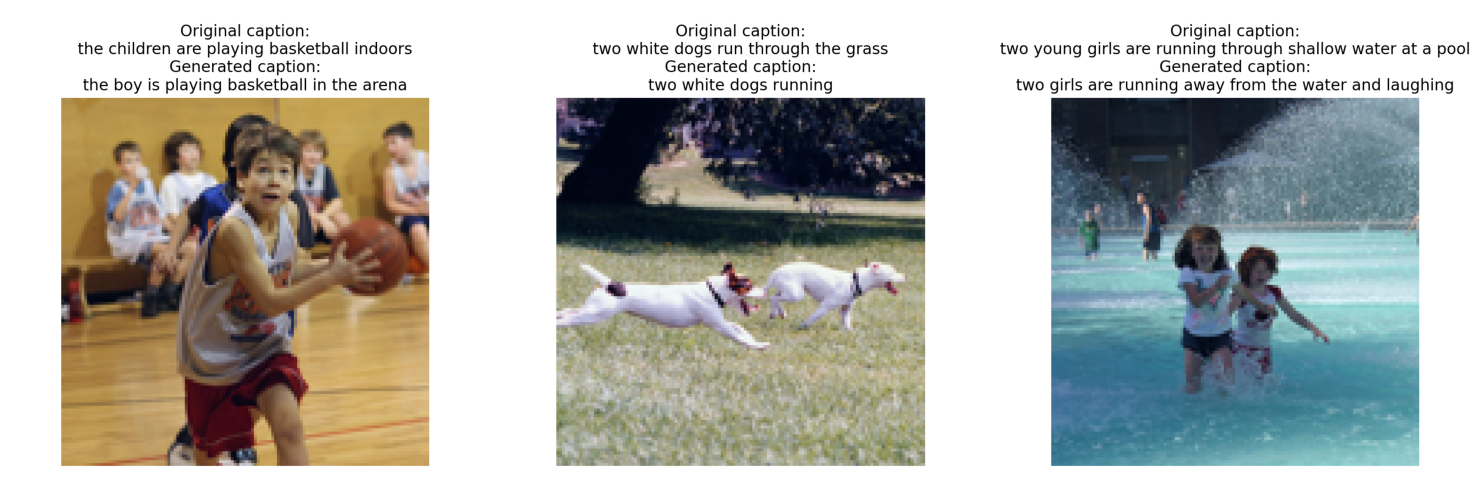